In [1]:
import pandas as pd

# 1. Load the cleaned data
df = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")

# 2. Flag readable vs unreadable
df["date_readable"] = df["publish_date_cleaned"].notna()

# 3. Per-source aggregation
stats = (
    df.groupby("source_domain")
      .agg(
         total_articles   = ("date_readable", "size"),
         readable_dates   = ("date_readable", "sum")
      )
      .reset_index()
)
stats["unreadable_dates"] = stats["total_articles"] - stats["readable_dates"]
stats["pct_readable"]     = 100 * stats["readable_dates"] / stats["total_articles"]

# 4. Overall summary
overall = pd.DataFrame({
    "total_articles":   [len(df)],
    "readable_dates":   [df["date_readable"].sum()],
    "unreadable_dates":[ (~df["date_readable"]).sum() ],
    "pct_readable":     [df["date_readable"].mean() * 100]
})

# 5. Print results
print("Per-Source Date Readability Stats:")
print(stats.sort_values("pct_readable").to_string(index=False))
print("\nOverall Date Readability Summary:")
print(overall.to_string(index=False))


Per-Source Date Readability Stats:
     source_domain  total_articles  readable_dates  unreadable_dates  pct_readable
 indianexpress.com            2818            2622               196     93.044713
           bbc.com            2376            2253               123     94.823232
      newsweek.com            2163            2153                10     99.537679
    abcnews.go.com             747             747                 0    100.000000
           cnn.com            2085            2085                 0    100.000000
   dailymail.co.uk            2990            2990                 0    100.000000
        apnews.com            3584            3584                 0    100.000000
          cnbc.com             582             582                 0    100.000000
       foxnews.com            2749            2749                 0    100.000000
     express.co.uk            1919            1919                 0    100.000000
 independent.co.uk            6511            6511  

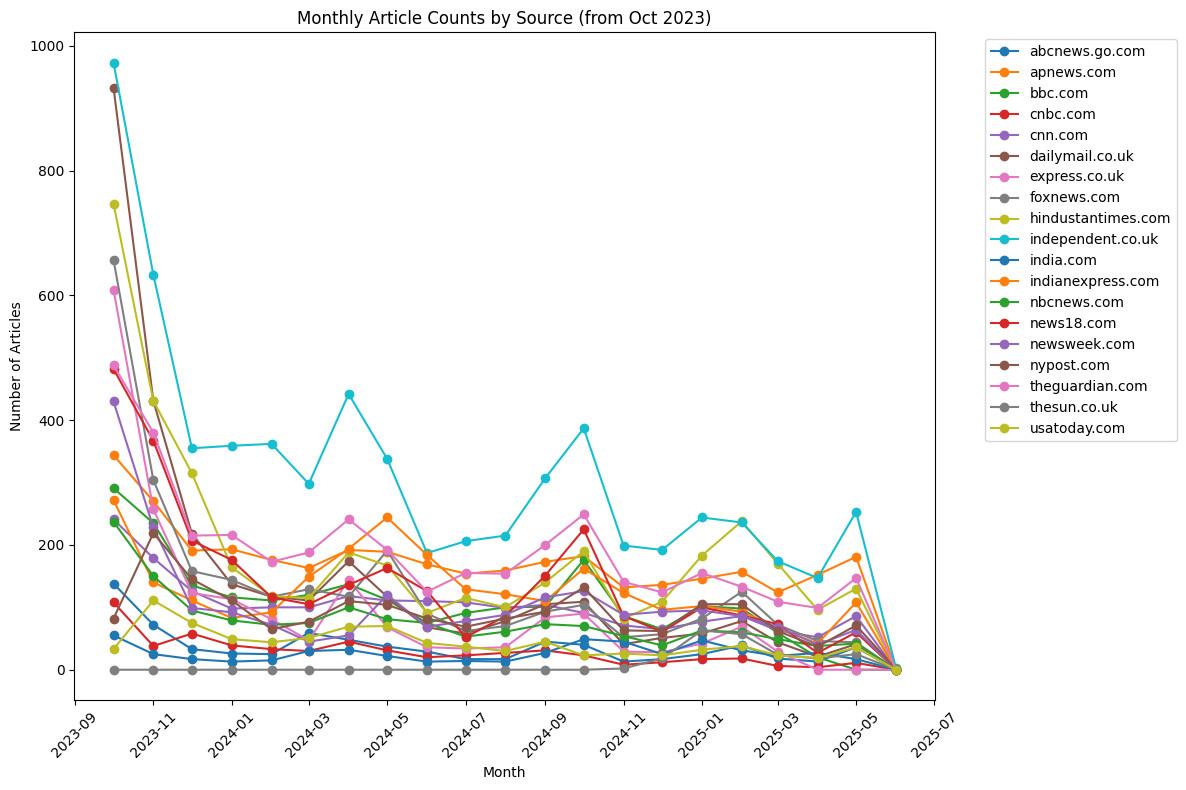

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load cleaned articles with dates
df = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet", engine="pyarrow")

# 2. Keep only rows with valid cleaned dates
df = df[df["publish_date_cleaned"].notna()]

# 3. Extract year-month for grouping
df["year_month"] = (
    pd.to_datetime(df["publish_date_cleaned"])
      .dt.to_period("M")
      .dt.to_timestamp()
)

# 4. Count articles per source per month
counts = (
    df
    .groupby(["year_month", "source_domain"])
    .size()
    .unstack("source_domain")
    .fillna(0)
)

# 5. Filter to start from October 2023
counts_filtered = counts.loc[counts.index >= "2023-10-01"]

# 6. Plot
plt.figure(figsize=(12, 8))
for src in counts_filtered.columns:
    plt.plot(counts_filtered.index, counts_filtered[src], marker='o', label=src)
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.title("Monthly Article Counts by Source (from Oct 2023)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [3]:
df_articles= pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")
df_image_index= pd.read_parquet("../data/blip_captioned_images.parquet")

print(df_articles.columns)
print(df_image_index.columns)

Index(['id', 'title', 'description', 'text', 'url', 'source_domain',
       'date_published', 'authors', 'keywords', 'matched_keywords',
       'predicted_label', 'label_index', 'publish_date_cleaned',
       'date_readable'],
      dtype='object')
Index(['image_id', 'article_id', 'source_domain', 'image_url', 'caption',
       'local_img_path', 'blip_caption'],
      dtype='object')


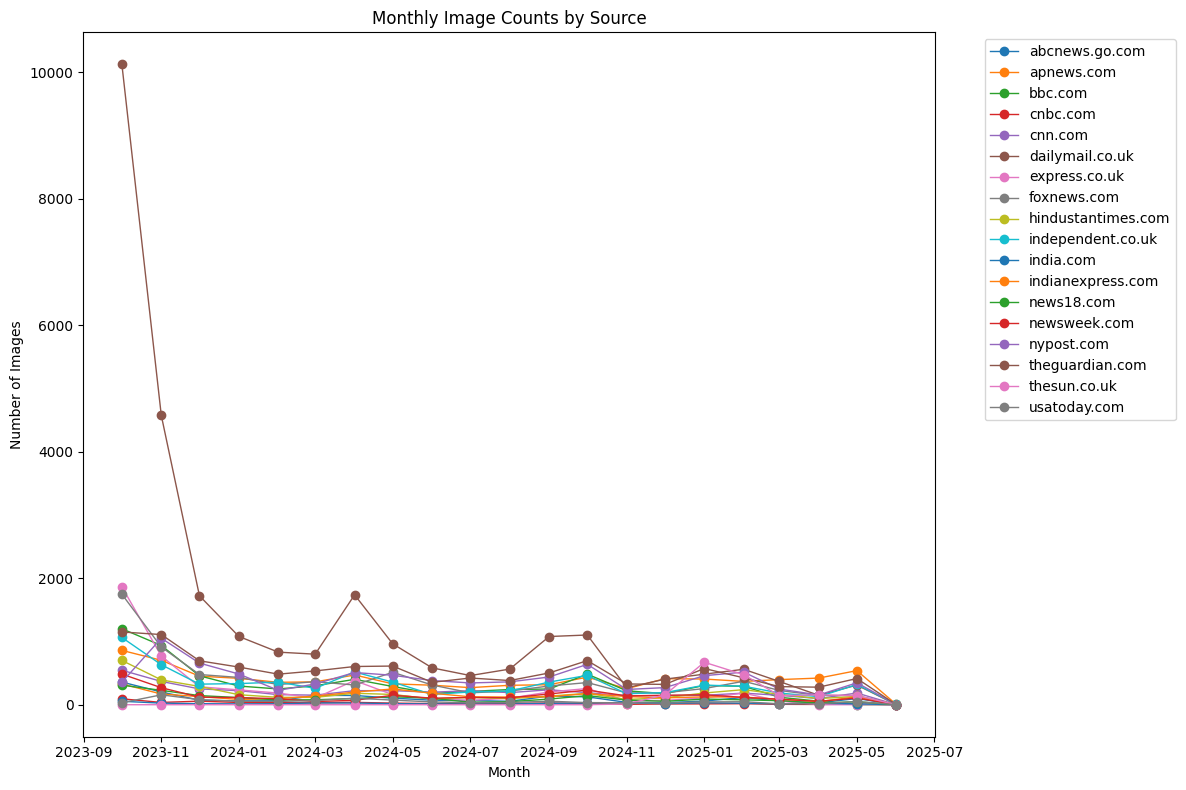

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load both tables
df_articles    = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")
df_image_index = pd.read_parquet("../data/blip_captioned_images.parquet")

# 2. Keep only articles with a parsed date
df_articles = df_articles[df_articles["publish_date_cleaned"].notna()]

# 3. Merge images ← articles, suffixing to avoid collision
df = df_image_index.merge(
    df_articles[["id","publish_date_cleaned","source_domain"]],
    left_on="article_id",
    right_on="id",
    how="inner",
    suffixes=("_img","_art")
)

# 4. Rename the image‐side domain to a uniform name
df = df.rename(columns={"source_domain_img":"source_domain"})

# 5. Drop the article‐side domain (optional)
df = df.drop(columns=["source_domain_art","id"])

# 6. Extract Year-Month bins
df["year_month"] = (
    pd.to_datetime(df["publish_date_cleaned"])
      .dt.to_period("M")
      .dt.to_timestamp()
)

# 7. Count images per source per month
counts = (
    df
    .groupby(["year_month","source_domain"])
    .size()
    .unstack("source_domain")
    .fillna(0)
)

# 8. (Optional) restrict to from Oct 2023
counts = counts.loc[counts.index >= "2023-10-01"]

# 9. Plot
plt.figure(figsize=(12, 8))
for src in counts.columns:
    plt.plot(counts.index, counts[src], marker="o", linewidth=1, label=src)

plt.xlabel("Month")
plt.ylabel("Number of Images")
plt.title("Monthly Image Counts by Source")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd

# Load merged image + article table (with cleaned dates & source_domain)
df = pd.read_parquet("../data/blip_captioned_images.parquet")\
       .merge(
           pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")[["id","publish_date_cleaned"]],
           left_on="article_id", right_on="id", how="left"
        )

# Keep only rows with a valid date
df = df[df["publish_date_cleaned"].notna()]

# Extract month
df["year_month"] = pd.to_datetime(df["publish_date_cleaned"])\
                      .dt.to_period("M")\
                      .dt.to_timestamp()

# Filter to Guardian & CNN
df_gc = df[df["source_domain"].isin(["theguardian.com","cnn.com"])]

# Group & count
monthly = (
    df_gc
    .groupby(["source_domain","year_month"])
    .size()
    .reset_index(name="image_count")
)

# Pivot for easy inspection
pivot = monthly.pivot(index="year_month", columns="source_domain", values="image_count").fillna(0)

print(pivot.sort_values(by="theguardian.com", ascending=False).head(10))
print(pivot.sort_values(by="cnn.com", ascending=False).head(10))


source_domain  cnn.com  theguardian.com
year_month                             
2023-10-01         545             1150
2023-11-01         368             1109
2024-10-01         190              697
2023-12-01         250              694
2024-05-01         222              611
2024-04-01         222              604
2024-01-01         222              595
2025-01-01         148              572
2024-03-01         151              534
2024-09-01         236              502
source_domain  cnn.com  theguardian.com
year_month                             
2023-10-01         545             1150
2023-11-01         368             1109
2023-12-01         250              694
2024-09-01         236              502
2024-01-01         222              595
2024-05-01         222              611
2024-04-01         222              604
2024-07-01         221              422
2024-06-01         198              354
2024-08-01         191              382


In [7]:
import pandas as pd

# 1. Load both tables
df_img = pd.read_parquet("../data/blip_captioned_images.parquet")
df_art = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")[
    ["id","url","publish_date_cleaned","source_domain"]
]

# 2. Merge images ← articles, keeping the article’s source_domain
df = df_img.merge(
    df_art,
    left_on="article_id",
    right_on="id",
    how="inner",
    suffixes=("_img","_art")
)

# 3. Rename so we have a single source_domain column
df = df.rename(columns={"source_domain_art":"source_domain"}).drop(columns=["source_domain_img","id"])

# 4. Drop any rows without a cleaned date
df = df[df["publish_date_cleaned"].notna()]

# 5. Compute year_month
df["year_month"] = (
    pd.to_datetime(df["publish_date_cleaned"])
      .dt.to_period("M")
      .dt.to_timestamp()
)

# 6. Now define a helper to show top‐image articles for a given source/month
def top_articles(src, ym, top_n=10):
    sub = df[(df["source_domain"]==src) & (df["year_month"]==pd.Timestamp(ym))]
    vc = sub["url"].value_counts().head(top_n)
    print(f"\n=== {src} top {top_n} articles for {ym} ({len(sub)} images) ===")
    print(vc.to_string())

# 7. Invoke it for the spike months:
top_articles("cnn.com",        "2023-10-01", top_n=10)
top_articles("cnn.com",        "2023-11-01", top_n=10)
top_articles("theguardian.com","2023-10-01", top_n=10)
top_articles("theguardian.com","2023-11-01", top_n=10)



=== cnn.com top 10 articles for 2023-10-01 (545 images) ===
url
https://www.cnn.com/2023/10/11/politics/presidents-israel-cnn                               12
https://www.cnn.com/2023/10/25/middleeast/satellite-images-gaza-destruction                 10
https://www.cnn.com/2023/10/16/middleeast/israel-gaza-hamas-week-2-monday-intl-hnk           9
https://www.cnn.com/2023/10/09/us/us-victims-israel-gaza                                     9
https://www.cnn.com/2023/10/11/world/global-protests-israel-hamas-war-intl-cmd               8
https://www.cnn.com/2023/10/09/middleeast/israel-hamas-music-festival-aftermath-intl-hnk     8
https://www.cnn.com/2023/10/09/middleeast/hamas-attack-strategy-israel-mime-intl             7
https://www.cnn.com/2023/10/12/world/israelis-returning-home-hamas-attack-intl               7
https://www.cnn.com/2023/10/14/middleeast/gaza-israel-evacuation-saturday-intl-hnk           7
https://www.cnn.com/2023/10/13/middleeast/israel-gaza-hamas-war-friday-intl-hnk 

In [8]:
df_articles= pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")
df_image_index= pd.read_parquet("../data/blip_captioned_images.parquet")

print(df_articles.columns)
print(df_image_index.columns)

Index(['id', 'title', 'description', 'text', 'url', 'source_domain',
       'date_published', 'authors', 'keywords', 'matched_keywords',
       'predicted_label', 'label_index', 'publish_date_cleaned',
       'date_readable'],
      dtype='object')
Index(['image_id', 'article_id', 'source_domain', 'image_url', 'caption',
       'local_img_path', 'blip_caption'],
      dtype='object')
